# Проект: вариант 1


## Задание 1  
_Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)_

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
import numpy as np
from scipy.stats import chi2_contingency 
import requests
from urllib.parse import urlencode
import scipy.stats as stats
from scipy.stats import normaltest, levene
import io

**Загрузка и ознакомление с данными** 

In [2]:
# Загрузка данных 
reg_data = pd.read_csv('/homedir/shared/problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('/homedir/shared/problem1-auth_data.csv', sep = ';')

In [3]:
#предварительный просмотр данных и понимание структуры
#reg_data - данные о времени регистрации

reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
#auth_data – данные о времени захода пользователей в игру
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
#Общая информация о данных

In [6]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [7]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [8]:
#Проверка на дубли
auth_data.duplicated().sum()

0

In [9]:
reg_data.duplicated().sum()

0

In [26]:
#Уникальные пользователи (uid) 
reg_data.uid.nunique()

1000000

In [27]:
auth_data.uid.nunique()

1000000

In [28]:
#Проверка на наличие пропущенных значений
reg_data.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [29]:
#Проверка на наличие пропущенных значений
auth_data.isnull().sum()

auth_ts    0
uid        0
dtype: int64

In [30]:
#Убедимся, что все зарегистрированные пользователи хотя бы раз присутствуют в таблице авторизаци
missing_in_auth = reg_data[~reg_data['uid'].isin(auth_data['uid'])]
n_missing = len(missing_in_auth)

In [31]:
# Пользователи из reg_data, которых нет в auth_data
n_missing

0

In [32]:
# Преобразование timestamp в даты
reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date

In [33]:
#Минимальная дата регистрации
reg_data["reg_date"].min()

datetime.date(1998, 11, 18)

In [34]:
#Максимальная дата регистрации
reg_data["reg_date"].max()

datetime.date(2020, 9, 23)

In [35]:
#Минимальная дата авторизации
auth_data["auth_date"].min()

datetime.date(1998, 11, 18)

In [36]:
#Максимальщная дата авторизации 
auth_data["auth_date"].max()

datetime.date(2020, 9, 23)

**Функция Retention**

In [37]:
def retention_by_day(reg_data, auth_data, year, month):
    """
    Рассчитывает месячный retention по дням с визуализацией.
    
    Параметры:
    - reg_data: DataFrame с данными о регистрации
    - auth_data: DataFrame с данными об авторизации
    - year: год анализа (int)
    - month: месяц анализа (int, 1–12)
    """
    
    # 1. Приводим столбцы к datetime
    reg_data['reg_date'] = pd.to_datetime(reg_data['reg_date'])
    auth_data['auth_date'] = pd.to_datetime(auth_data['auth_date'])
    
    # 2. Определяем границы месяца как pd.Timestamp
    start_ts = pd.Timestamp(year, month, 1)
    end_ts = start_ts + pd.offsets.MonthEnd(0)
    
    # Для сравнения: берём .date() от Timestamp
    start_date = start_ts.date()
    end_date = end_ts.date()
    
    # 3. Фильтруем данные
    reg_filtered = reg_data[
        (reg_data['reg_date'].dt.date >= start_date) &
        (reg_data['reg_date'].dt.date <= end_date)
    ].copy()

    auth_filtered = auth_data[
        (auth_data['auth_date'].dt.date >= start_date) &
        (auth_data['auth_date'].dt.date <= end_date)
    ].copy()

    if reg_filtered.empty or auth_filtered.empty:
        raise ValueError("Нет данных за указанный период ({}-{:02d})".format(year, month))

    # 4. Объединяем и очищаем
    merged = auth_filtered.merge(reg_filtered[['uid', 'reg_date']], on='uid', how='left')
    merged = merged.dropna(subset=['reg_date'])  # убираем строки без даты регистрации

    # 5. Считаем дни с момента регистрации
    merged['days_since_reg'] = (
        pd.to_datetime(merged['auth_date']).dt.date -
        pd.to_datetime(merged['reg_date']).dt.date
    ).dt.days

    # 6. Группируем по когортам 
    cohorts = (
        merged.groupby(['reg_date', 'days_since_reg'])['uid']
        .nunique()
        .reset_index(name='user_count')
    )

    # 7. Создаём сводную таблицу 
    pivot = cohorts.pivot(
        index='reg_date',
        columns='days_since_reg',
        values='user_count'
    ).fillna(0)

    # 8. Рассчитываем retention
    retention = pivot.div(pivot[0], axis=0) 
    retention_percent = (retention * 100).round(1) 

    # 9. Размеры когорт 
    cohort_size = pivot[0].rename('Размер когорты')

    # 10. Убираем столбец day 0 из retention (он всегда 100%)
    retention_pivot_no_first = retention_percent.iloc[:, 1:]

    # 11. Визуализация
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(16, 10),
            sharey=True,
            gridspec_kw={'width_ratios': [1, 11]}
        )

        # Тепловая карта retention 
        sns.heatmap(
            retention_pivot_no_first,
            mask=(retention_pivot_no_first == 0),  
            annot=True,
            fmt='.1f',
            cmap='RdYlGn',
            cbar=False,
            ax=ax[1]
        )
        ax[1].set_title('Retention по дням (%, от размера когорты)', fontsize=16)
        ax[1].set_xlabel('Дней с регистрации')
        ax[1].set_ylabel('Когорта')
        
        # Тепловая карта размеров когорт 
        cohort_size_df = cohort_size.to_frame()
        cohort_size_df.index = cohort_size_df.index.date
        
        white_cmap = ListedColormap(['white'])
        sns.heatmap(
            cohort_size_df,
            annot=True,
            fmt='g',
            cmap=white_cmap,
            cbar=False,
            ax=ax[0]
        )
        ax[0].set_ylabel('Дата регистрации')

    plt.tight_layout()
    plt.show()


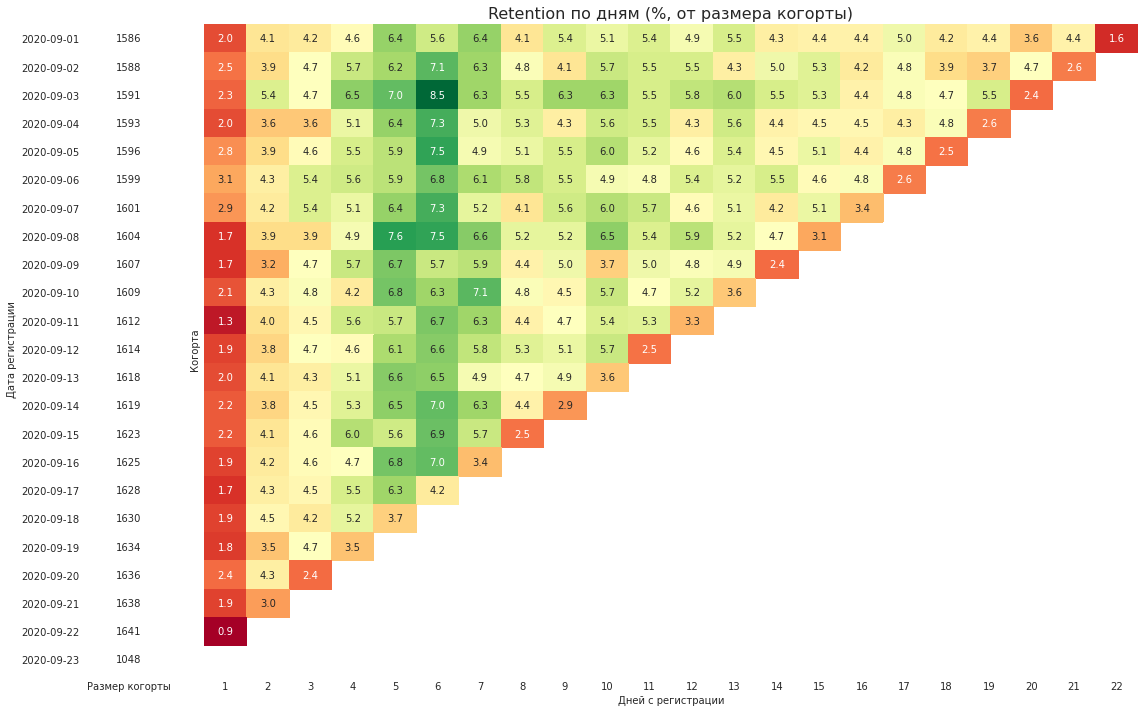

In [38]:
retention_by_day(reg_data, auth_data, 2020, 9)

## Задание 2
_В компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение._

**Загрузка и ознакомление с данными**

In [40]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и читаем в датафрейм

download_response = requests.get(download_url)
df = pd.read_csv(download_url, sep=';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


**Проверка и интерпритация данных**

In [41]:
#общая информация 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [42]:
#количестов строк и столбцов 
df.shape


(404770, 3)

In [43]:
#Проверка на дубли
df.duplicated().sum()

0

In [44]:
#Проверка на наличие пропущенных значений
df.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [45]:
#Количество уникальных значений 
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [46]:
#Количество пользователей в группах 
df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

In [47]:
#доход по каждой группе 
df.groupby("testgroup", as_index=False)["revenue"].sum()

,testgroup,revenue
0,a,5136189
1,b,5421603


In [48]:
#Разделяем на группы
control = df[df['testgroup'] == 'a']
test = df[df['testgroup'] == 'b']

In [49]:
#статистика контрльной группы 
control.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [50]:
#статистика тестовой группы 
test.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

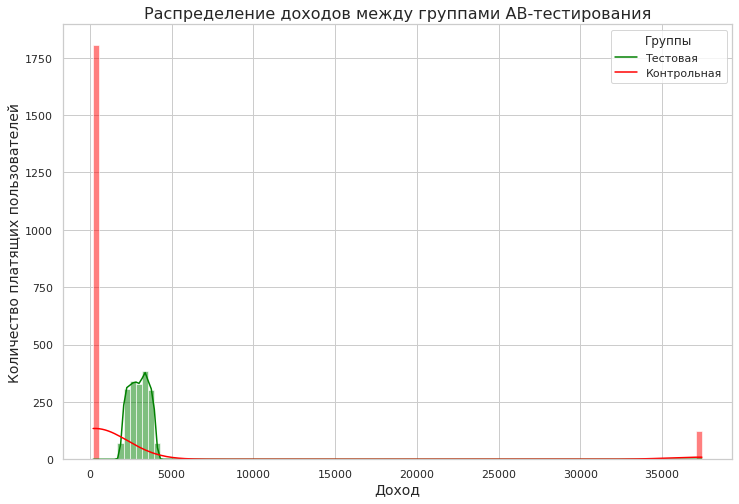

In [51]:
#Визуализация данных
#Построение гистограммы
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.histplot(data=df[df['revenue'] > 0], 
             x='revenue', 
             hue='testgroup', 
             kde=True, 
             bins=100,    
             stat='count',
             palette={'a': 'red', 'b': 'green'}) 

plt.title('Распределение доходов между группами AB-тестирования', fontsize=16)
plt.xlabel('Доход', fontsize=14)
plt.ylabel('Количество платящих пользователей', fontsize=14)
plt.legend(title='Группы', labels=['Тестовая' ,'Контрольная' ], loc='upper right')
plt.grid(True)
plt.show()

In [52]:

groups = df['testgroup'].unique()

results = {}

for group in groups:
    
    data = df[df['testgroup'] == group]['revenue']
    
    # Проводим тест Д’Агостино — Пирсона
    k2, p_value = stats.normaltest(data)
    
    results[group] = {
        'k2': k2,
        'p_value': p_value,
        'normal': p_value >= 0.05
    }

    print(f"Группа {group}:")
    print(f"  Статистика K²: {k2:.4f}")
    print(f"  p‑значение: {p_value:.4f}")
    print(f"  Нормальность: {'Да' if p_value >= 0.05 else 'Нет'}")
    print("-" * 30)

Группа b:
  Статистика K²: 326622.3954
  p‑значение: 0.0000
  Нормальность: Нет
------------------------------
Группа a:
  Статистика K²: 585152.7313
  p‑значение: 0.0000
  Нормальность: Нет
------------------------------


- Размер групп сопоставим (группа A: 202 103, группа B: 202 667), что обеспечивает корректность сравнительного анализа и снижает риск смещения результатов.  
- Средний доход на пользователя выше в группе B (26,75) чем в А (25,41).  
- Стандартное отклонение значительно выше в группе A (920,77) по сравнению с группой B (287,32), что указывает на то, что:
  - в группе A — высокий разброс доходов (наличие как нулевых, так и крайне высоких значений);  
  - в группе B — более однородные доходы, сконцентрированные вокруг среднего.  
- Максимальное значение дохода в группе A (37 433) существенно превышает таковое в группе B (4000), что объясняет повышенный разброс в контрольной группе.  
- Распределение доходов в обеих группах существенно отличается от нормального.  

**Гипотезы:**  

- H0 различия в между тестовой и контрольной группой не являются статистически значимыми (или различий нет);  
- H1 различия в между тестовой и контрольной группой являются статистически значимыми.  

**Метрики, которые будем проверять для проверки гипотезы и обоснование выбранных статистических тестов:**  

- **CR** (конверсия в платящего пользователя (число платящих пользователей/число пользователей * 100) - категориальная метрика (пользователь либо платит, либо нет). Применим хи квадрат для таблицы сопряжённости - проверяет, отличается ли наблюдаемое распределение конверсий от ожидаемого при нулевой гипотезе (отсутствие различий между группами), подходит для больших выборок.  


- **ARPU** (средний доход на пользователя (выручка/число пользователей) -количественная метрика, сравниваем средние; дисперсии в группах резко различаются, тест Уэлча корректирует степени свободы, учитывая неравенство дисперсий, благодаря центральной предельной теореме (ЦПТ), при больших выборках распределение средних стремится к нормальному, даже если исходные данные ненормальны, тест демонстрирует устойчивость к отклонениям от нормальности при больших объёмах данных.    


- **ARPPU** (средние траты каждого платящего пользователя (выручка/число платящих пользователей) - количественная метрика, тест Уэлча устойчив к неравенству дисперсий и большим выборкам; ЦПТ обеспечивает нормальность распределения средних даже при ненормальном исходном распределении благодаря большому размеру выборки.  



## CR

In [77]:
#платящие пользователи в группах
paying_control = (control["revenue"] > 0).sum()
paying_test = (test["revenue"] > 0).sum()

In [78]:
#всего пользователей в группах
n_control = len(control)
n_test = len(test)

In [79]:
#расчет CR
cr_control = paying_control / n_control if n_control > 0 else 0
cr_test = paying_test / n_test if n_test > 0 else 0

In [80]:
#конверсия в платящего в контрользой группе 
cr_control 

0.009539690157988749

In [81]:
#конверсия в платящего в тестовой группе 
cr_test

0.008906235351586593

In [82]:
# Переводим CR в абсолютные числа конверсий
conversions_control = int(cr_control * n_control)
conversions_test = int(cr_test * n_test)

In [83]:
# Строим таблицу сопряжённости (contingency table)
# [конверсии, неконверсии] для каждой группы
observed = np.array([
    [conversions_control, n_control - conversions_control],  # контрольная
    [conversions_test, n_test - conversions_test]           # тестовая
])

In [84]:
# 3. Хи-квадрат тест для сравнения конверсии (CR)
chi2, p_value, dof, expected = chi2_contingency(observed)


print(f"Хи‑квадрат (χ²): {chi2:.4f}")
print(f"p‑значение: {p_value:.4f}")
print(f"Степени свободы (dof): {dof}")
print(f"\nНаблюдаемые частоты:\n{observed}")
print(f"\nОжидаемые частоты (при H₀):\n{expected.astype(int)}")

Хи‑квадрат (χ²): 4.3747
p‑значение: 0.0365
Степени свободы (dof): 1

Наблюдаемые частоты:
[[  1928 200175]
 [  1805 200862]]

Ожидаемые частоты (при H₀):
[[  1863 200239]
 [  1869 200797]]


In [85]:
alpha = 0.05  # уровень значимости


if p_value < alpha:
    print("\nВывод: Разница в конверсии статистически значима (p < 0.05).")
    print("Отвергаем нулевую гипотезу: CR групп различается.")
else:
    print("\nВывод: Разница в конверсии не является статистически значимой (p >= 0.05).")
    print("Не отвергаем нулевую гипотезу: CR групп не отличается.")


Вывод: Разница в конверсии статистически значима (p < 0.05).
Отвергаем нулевую гипотезу: CR групп различается.


 ## ARPU

In [86]:
#доход в группах
revenue_control = control["revenue"].sum()
revenue_test = test["revenue"].sum()

In [87]:
#расчет ARPU
arpu_control = revenue_control / n_control if n_control > 0 else 0
arpu_test = revenue_test / n_test if n_test > 0 else 0

In [88]:
#средний доход на пользователя в контрольной группе 
arpu_control

25.413719736965806

In [89]:
#средний доход на пользователя в тестовой группе 
arpu_test

26.75128659327863

In [90]:
# Тест Уэлча (Welch's t-test) для сравнения ARPU между группами

arpu_t_stat, arpu_p_value = stats.ttest_ind(
    control["revenue"], 
    test["revenue"],
    equal_var=False  # Ключевой параметр для теста Уэлча
)

# Форматированный вывод результатов
print("Результаты теста Уэлча для ARPU:")
print(f"  t‑статистика: {arpu_t_stat:.4f}")
print(f"  p‑значение: {arpu_p_value:.4f}")
print(f"  Уровень значимости (α): 0.05")
print("Вывод: ", end="")
if arpu_p_value < 0.05:
    print("Наблюдаются статистически значимые различия между группами.")
else:
    print("Статистически значимых различий между группами не обнаружено.")


Результаты теста Уэлча для ARPU:
  t‑статистика: -0.6235
  p‑значение: 0.5330
  Уровень значимости (α): 0.05
Вывод: Статистически значимых различий между группами не обнаружено.


## ARPPU

In [69]:
#Расчитываем ARPPU
arppu_control = revenue_control / paying_control if paying_control > 0 else 0
arppu_test = revenue_test / paying_test if paying_test > 0 else 0

In [70]:
#средние траты каждого платящего пользователя в контрольной группе  
arppu_control

2663.9984439834025

In [71]:
#средние траты каждого платящего пользователя в тестовой группе 

In [72]:
arppu_test

3003.6581717451522

In [91]:
# Тест Уэлча (Welch's t-test) для сравнения ARPPU между группами

arppu_t_stat, arppu_p_value = stats.ttest_ind(
    control[control['revenue'] > 0]['revenue'],  # Платящие в контрольной группе
    test[test['revenue'] > 0]['revenue'],     # Платящие в тестовой группе
    equal_var=False  # Ключевой параметр для теста Уэлча
)


print("Результаты теста Уэлча для ARPPU:")
print(f"  t‑статистика: {arppu_t_stat:.4f}")
print(f"  p‑значение: {arppu_p_value:.4f}")
print(f"  Уровень значимости (α): 0.05")


print("Вывод: ", end="")
if arppu_p_value < 0.05:
    print("Наблюдаются статистически значимые различия между группами.")
else:
    print("Статистически значимых различий между группами не обнаружено.")


Результаты теста Уэлча для ARPPU:
  t‑статистика: -1.6446
  p‑значение: 0.1002
  Уровень значимости (α): 0.05
Вывод: Статистически значимых различий между группами не обнаружено.


## Вывод:

Средний доход на пользователя и средние траты каждого платящего пользователя в тестовой группе выше,но при этом эти различие оказались статистически незначимы.  

Конверсия в платящего клиента в тестовой группе снизилась по сравнению с контрольной группой. Это негативный сигнал: изменения, внесённые в тестовую версию, вероятно, ухудшили способность привлекать целевые действия.  

Таким образом, акционное предложение не было эффективным или даже имело негативное влияние на вовлеченность новых платящих пользователей. Это свидетельствует о том, что тестируемые изменения не приводят к улучшению. Применять на всех пользователей нельзя. 


## Задание 3

*В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени.  
В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы.  
Для получения награды требуется пройти ряд уровней за определенное время.  
С помощью каких метрик можно оценить результаты последнего прошедшего события?*  

*Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?*  

**Метрики для оценки стандартного тематического события в Plants & Gardens**  

 **1. Охват и вовлечение:**  
   - Event Participation Rate- доля активных игроков, вступивших в событие.  
   - New User Conversion - число новых игроков, привлечённых событием.    
   - Time Spent Per Participant - среднее время, проведённое в событии.  
    
**2. Удержание (Retention):**  
   - D1/D3/D7 Retention Post‑Event - процент участников, вернувшихся через 1/3/7 дней после завершения события.  
   - Churn Rate During Event - доля игроков, покинувших событие до завершения.  
   
**3. Монетизация (Revenue)**
   - ARPU (Event) - средний доход с участника события.
   - Paying Conversion Rate - доля платящих среди всех участников.
   - AOV (Event) - средний чек внутри события.

   
**Как изменится набор метрик при введении механики «отката на уровни».**  
Новая механика добавляет риск фрустрации и увеличение времени на прохождение, поэтому к базовому набору добавляются:

**1. Метрики сложности и фрустрации**  
   - Rollback Frequency -среднее число откатов на игрока.
 
   
**2. Изменение паттернов прохождения**
   - Attempts Per Level - среднее число попыток на уровень.

   
**3. Влияние на монетизацию и удержание** 
   - ARPU Lift from Rollbacks - как изменилась монетизация из‑за механики откатов.
   - Retention Penalty - как изменилось удержание на 1‑й день после события.

